In [39]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [ ]:
def unet_model(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:




def load_dataset(image_dir, label_dir, img_size=(128, 128), batch_size=32):
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        image_dir,
        label_mode=None,
        image_size=img_size,
        batch_size=batch_size
    )

    label_dataset = tf.keras.utils.image_dataset_from_directory(
        label_dir,
        label_mode=None,
        image_size=img_size,
        batch_size=batch_size
    )

    # Convert labels to grayscale
    label_dataset = label_dataset.map(lambda x: tf.image.rgb_to_grayscale(x) / 255.0)

    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    return dataset


In [32]:
# Paths to image and label directories
image_dir = "C:/Users/AKASH/Desktop/semantic segmentation/semantic segmentation/Images"
label_dir = "C:/Users/AKASH/Desktop/semantic segmentation/semantic segmentation/Labels"

In [33]:
# Parameters
input_shape = (128, 128, 3)  # Image dimensions
batch_size = 16
# Prepare dataset
dataset = load_dataset(image_dir, label_dir, img_size=(128, 128), batch_size=batch_size)
train_dataset = dataset.take(int(len(dataset) * 0.8))
val_dataset = dataset.skip(int(len(dataset) * 0.8))

Found 179 files belonging to 1 classes.
Found 179 files belonging to 1 classes.


In [34]:
# Compile and train model
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
9/9 [==============================] - 338s 36s/step - loss: 6.4942 - accuracy: 0.3368 - val_loss: 1.1540 - val_accuracy: 0.0261
Epoch 2/3
9/9 [==============================] - 231s 25s/step - loss: 0.7399 - accuracy: 0.4943 - val_loss: 0.6747 - val_accuracy: 0.5193
Epoch 3/3
9/9 [==============================] - 256s 28s/step - loss: 0.6756 - accuracy: 0.5087 - val_loss: 0.6826 - val_accuracy: 0.2545


1/1 [==============================] - 0s 338ms/step


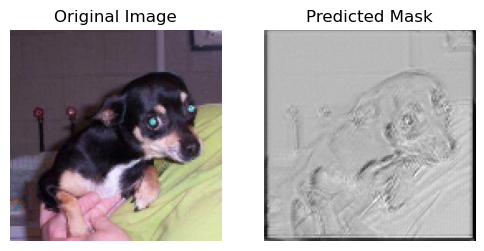

Predicted mask shape: (1, 128, 128, 1)


In [38]:
import numpy as np
import matplotlib.pyplot as plt


image_batch, label_batch = next(iter(train_dataset))
sample_image = image_batch[0]  

# Display the original image
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis('off')

# Make prediction
sample_image_resized = tf.image.resize(sample_image, input_shape[:2])  # Resize to input shape if necessary
sample_image_resized = tf.expand_dims(sample_image_resized, axis=0)  # Add batch dimension

predicted_mask = model.predict(sample_image_resized)

# Display the predicted segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0].squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')
plt.show()

# You can also print the shape of the predicted mask to ensure it's correct
print(f"Predicted mask shape: {predicted_mask.shape}")
